In [1]:
# ロジスティック回帰のROC曲線
#
# 2015/04/24 ver1.0
#

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import rand, multivariate_normal
pd.options.mode.chained_assignment = None

%matplotlib inline

In [2]:
#------------#
# Parameters #
#------------#
Variances = [50,150] # 両クラス共通の分散（2種類の分散で計算を実施）


In [3]:
# データセット {x_n,y_n,type_n} を用意
def prepare_dataset(variance):
    n1 = 80
    n2 = 200
    mu1 = [9,9]
    mu2 = [-3,-3]
    cov1 = np.array([[variance,0],[0,variance]])
    cov2 = np.array([[variance,0],[0,variance]])

    df1 = DataFrame(multivariate_normal(mu1,cov1,n1),columns=['x','y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(mu2,cov2,n2),columns=['x','y'])
    df2['type'] = 0
    df = pd.concat([df1,df2],ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index()
    return df[['x','y','type']]


In [7]:
# ロジスティック回帰を実施
def run_simulation(variance, subplot):
    training_set = prepare_dataset(variance)
    training_set1 = training_set[training_set['type']==1]
    training_set2 = training_set[training_set['type']==0]
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    subplot.set_ylim([ymin-1, ymax+1])
    subplot.set_xlim([xmin-1, xmax+1])
    # 分類データを表示
    subplot.scatter(training_set1.x, training_set1.y, marker='o')
    subplot.scatter(training_set2.x, training_set2.y, marker='x')

    training_set['bias'] = 1
    w = np.array([[0],[0.1],[0.1]])
    phi = training_set[['bias','x','y']]
    phi = phi.as_matrix(columns=['bias','x','y'])
    t = training_set[['type']]
    t = t.as_matrix()

    # 最大100回のIterationを実施
    for i in range(100):
        # IRLS法によるパラメータの修正
        y = np.array([])
        for line in phi:
            a = np.dot(line, w)
            y = np.append(y, [1.0/(1.0+np.exp(-a))])
        r = np.diag(y*(1-y)) 
        y = y[np.newaxis,:].T
        tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r),phi))
        tmp2 = np.dot(phi.T, (y-t))
        w_new = w - np.dot(tmp1, tmp2)
        # パラメータの変化が 0.1% 未満になったら終了
        if np.dot((w_new-w).T, (w_new-w)) < 0.001 * np.dot(w.T, w):
            w = w_new
            break
        w = w_new

    # 分類誤差の計算と確率付きデータの用意
    d0, dx, dy = w[0], w[1], w[2]
    err = 0
    training_set['probability'] = 0.0
    for index, line in training_set.iterrows():
        a = np.dot(np.array([1, line.x, line.y]), w)
        p = 1.0/(1.0+np.exp(-a))
        training_set.ix[index, 'probability'] = p
        if (p-0.5)*(line.type*2-1) < 0:
            err += 1
    err_rate = err * 100 / len(training_set)
    # 境界線（P=0.5）を表示
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * dx / dy - d0 / dy
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex,liney ,label=label, color='blue')
    subplot.legend(loc=1)
    # result = training_set.sort_index(by=['probability'], ascending=[False])
    result = training_set.sort_values(by=['probability'], ascending=[False])
    # 確率付きデータを返却
    return result.reset_index()

In [5]:
# ROC曲線の表示
def draw_roc(result, subplot):
    positives = len(result[result['type']==1])
    negatives = len(result[result['type']==0])
    tp = [0.0] * len(result)
    fp = [0.0] * len(result)
    for index, line in result.iterrows():
        for c in np.arange(0, len(result)):
            if index < c:
                if line.type == 1:
                    tp[c] += 1
                else:
                    fp[c] += 1
    tp_rate = np.array(tp) / positives
    fp_rate = np.array(fp) / negatives

    subplot.set_ylim([0, 1])
    subplot.set_xlim([0, 1])
    subplot.set_xlabel("False positive rate")
    subplot.set_ylabel("True positive rate")
    subplot.plot(fp_rate, tp_rate)


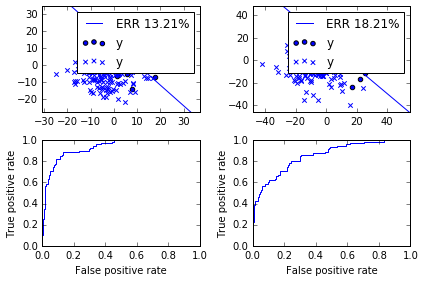

In [8]:
fig = plt.figure()
for c, variance in enumerate(Variances):
    subplots = fig.add_subplot(2,2,c+1)
    result = run_simulation(variance, subplots)
    subplots = fig.add_subplot(2,2,c+2+1)
    draw_roc(result, subplots)

plt.tight_layout()